In [23]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import re
import scipy
import itertools
import pickle
import os.path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF as sm_ECDF
import statsmodels.formula.api as smf
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import attila_utils
import gem_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ar = gem_tools.read_active_reactions(groupdict={'m-control': ('all_control', 'MSBB'), 'm-AD-B2': ('SubtypeB2_AD', 'MSBB')})

In [3]:
gemsubsys = gem_tools.read_gem_excel()['SUBSYSTEM']
gemsubsys

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


ID
MAR03905       Glycolysis / Gluconeogenesis
MAR03907       Glycolysis / Gluconeogenesis
MAR04097       Glycolysis / Gluconeogenesis
MAR04099       Glycolysis / Gluconeogenesis
MAR04108       Glycolysis / Gluconeogenesis
                         ...               
MAR10129             Bile acid biosynthesis
MAR10130             Bile acid biosynthesis
MAR10131             Bile acid biosynthesis
MAR10132          Exchange/demand reactions
MAR13083    Metabolism of other amino acids
Name: SUBSYSTEM, Length: 13069, dtype: object

['named-figure/subsystem-rxn-counts.png',
 'named-figure/subsystem-rxn-counts.pdf']

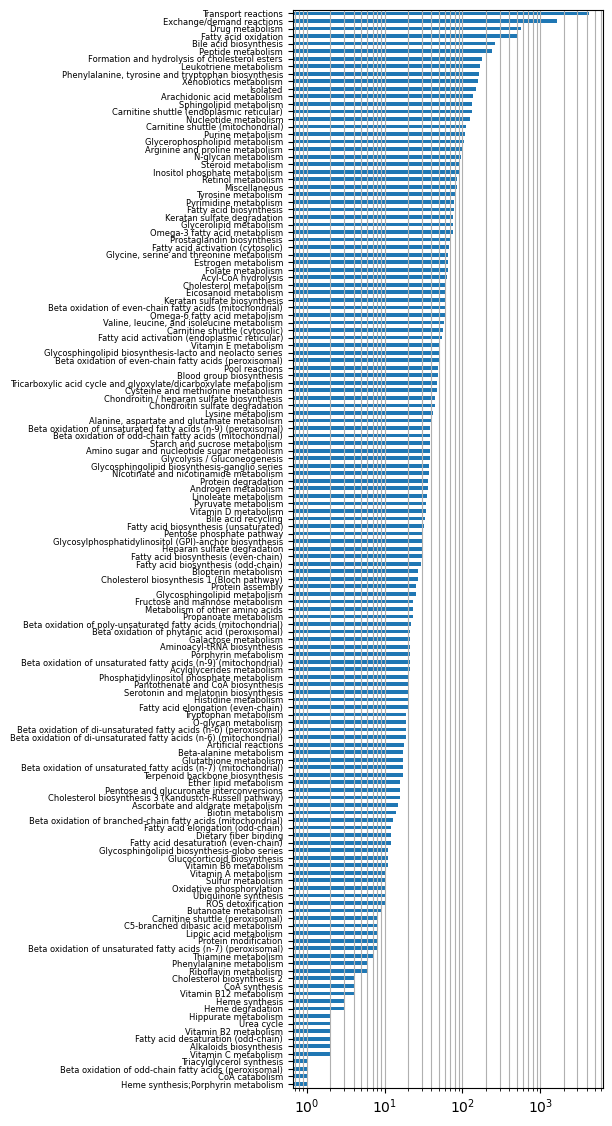

In [4]:
def subsystem_rxn_count(gemsubsys=gemsubsys, topk=None):
    fig, ax = plt.subplots(figsize=(4, 14 if topk is None else 6))
    s = gemsubsys.value_counts(sort=True, ascending=True)
    s = s if topk is None else s.iloc[-topk:]
    s.plot(kind='barh')
    ax.set_xscale('log')
    ax.grid(axis='x', which='both')
    ax.tick_params(axis='y', labelsize=6 if topk is None else 8)
    return((fig, ax))

fig, ax = subsystem_rxn_count()
attila_utils.savefig(fig, 'subsystem-rxn-counts')

['named-figure/subsystem-rxn-counts-top40.png',
 'named-figure/subsystem-rxn-counts-top40.pdf']

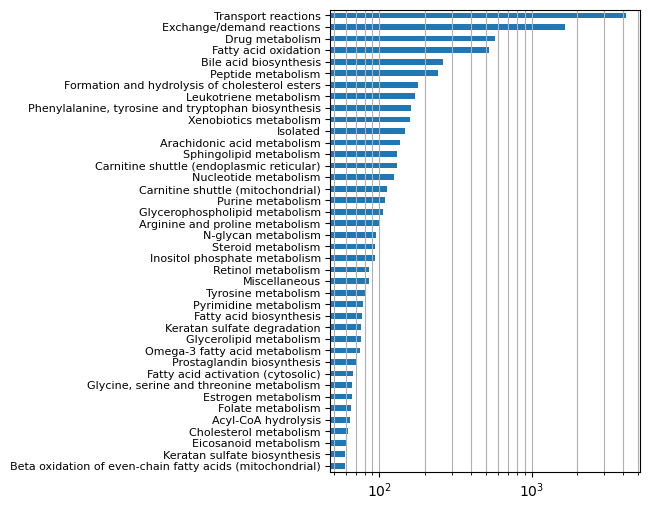

In [5]:
fig, ax = subsystem_rxn_count(topk=40)
attila_utils.savefig(fig, 'subsystem-rxn-counts-top40')

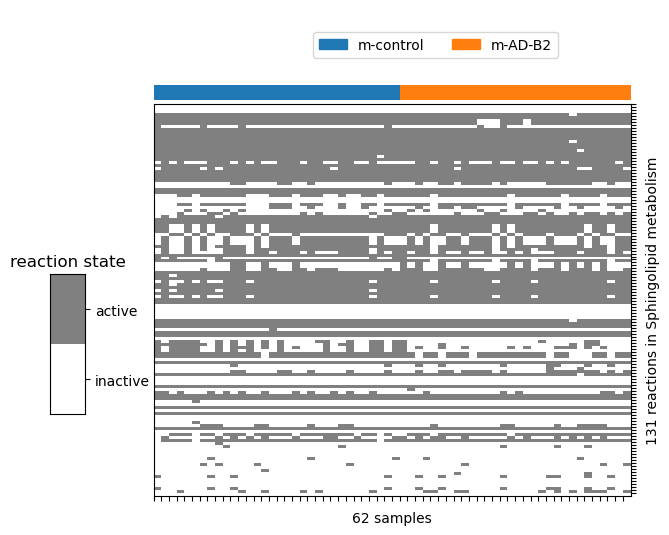

In [6]:
def extract_subsystem(subsystems, ar=ar, gemsubsys=gemsubsys):
    l = [ar[k].loc[gemsubsys.loc[gemsubsys.isin(subsystems)].index] for k in ar.keys()]
    df = pd.concat(l, axis=1)
    return(df)


def my_clustermap(subsystems, ar=ar, gemsubsys=gemsubsys, col_cluster=False):
    df = extract_subsystem(subsystems, ar=ar, gemsubsys=gemsubsys)
    coldict = {g: 'C' + str(i) for i, g in enumerate(ar.keys())}
    col_colors = list(itertools.chain(*[[v] * ar[k].shape[1] for k, v in coldict.items()]))
    cmap = ['white', 'gray']
    g = sns.clustermap(df, row_cluster=False, col_cluster=col_cluster, col_colors=col_colors, cmap=cmap, figsize=(7,7),dendrogram_ratio=0.15)
    handles = [mpatches.Patch(color=c) for c in coldict.values()]
    g.fig.legend(handles, ar.keys(), loc='lower center', bbox_to_anchor=(0.3, 0.9 + 0.1 * col_cluster, 0.5, 0.1), ncol=2)
    g.ax_heatmap.set_xlabel(str(df.shape[1]) + ' samples')
    g.ax_heatmap.set_xticklabels('')
    g.ax_heatmap.set_xticks(range(df.shape[1]))
    subsys_str = ', '.join(subsystems)
    suffix = ' in ' + subsys_str if len(subsys_str) <= 50 else ''
    g.ax_heatmap.set_ylabel(str(df.shape[0]) + ' reactions' + suffix)
    g.ax_heatmap.set_yticklabels('')
    g.ax_heatmap.set_yticks(range(df.shape[0]))
    g.ax_cbar.set_position((0, 0.4, 0.05, 0.2))
    g.ax_cbar.set_title('reaction state')
    g.ax_cbar.set_yticks([0.25, 0.75])
    g.ax_cbar.set_yticklabels(['inactive', 'active'])
    g.ax_cbar.set_ylim([0, 1])
    for spine in g.ax_heatmap.spines.values():
        spine.set_visible(True)
    for spine in g.ax_cbar.spines.values():
        spine.set_visible(True)
    return(g)

g = my_clustermap(['Sphingolipid metabolism'], col_cluster=False)

In [7]:
pathways = pd.read_csv('../../resources/tunahan/Busra-2023-02-05/subsystem-pathway.csv')
pathways = pathways.groupby('pathway')['subsystem'].apply(lambda x: x.to_numpy())
pathways

pathway
Bile acid metabolism                             [Bile acid biosynthesis, Bile acid recycling]
Carnitine shuttle                            [Carnitine shuttle (cytosolic), Carnitine shut...
Cholesterol metabolism                       [Cholesterol biosynthesis 1 (Bloch pathway), C...
Fatty acid metabolism                        [Fatty acid activation (cytosolic), Fatty acid...
Glycerolipid metabolism                      [Glycerophospholipid metabolism, Glycerolipid ...
Glycosphingolipid metabolism                 [Glycosphingolipid biosynthesis-ganglio series...
Phosphatidylinositol phosphate metabolism    [Glycosylphosphatidylinositol (GPI)-anchor bio...
Name: subsystem, dtype: object

In [8]:
fatty_acid_pathway = pathways.loc['Fatty acid metabolism']
fatty_acid_pathway

array(['Fatty acid activation (cytosolic)',
       'Fatty acid activation (endoplasmic reticular)',
       'Fatty acid biosynthesis (even-chain)',
       'Fatty acid biosynthesis (odd-chain)',
       'Fatty acid biosynthesis (unsaturated)',
       'Fatty acid elongation (even-chain)',
       'Fatty acid elongation (odd-chain)',
       'Fatty acid desaturation (even-chain)',
       'Fatty acid desaturation (odd-chain)', 'Fatty acid biosynthesis',
       'Beta oxidation of even-chain fatty acids (peroxisomal)',
       'Beta oxidation of odd-chain fatty acids (peroxisomal)',
       'Beta oxidation of unsaturated fatty acids (n-9) (peroxisomal)',
       'Beta oxidation of phytanic acid (peroxisomal)',
       'Beta oxidation of di-unsaturated fatty acids (n-6) (peroxisomal)',
       'Beta oxidation of even-chain fatty acids (mitochondrial)',
       'Beta oxidation of odd-chain fatty acids (mitochondrial)',
       'Beta oxidation of unsaturated fatty acids (n-7) (mitochondrial)',
       'Bet

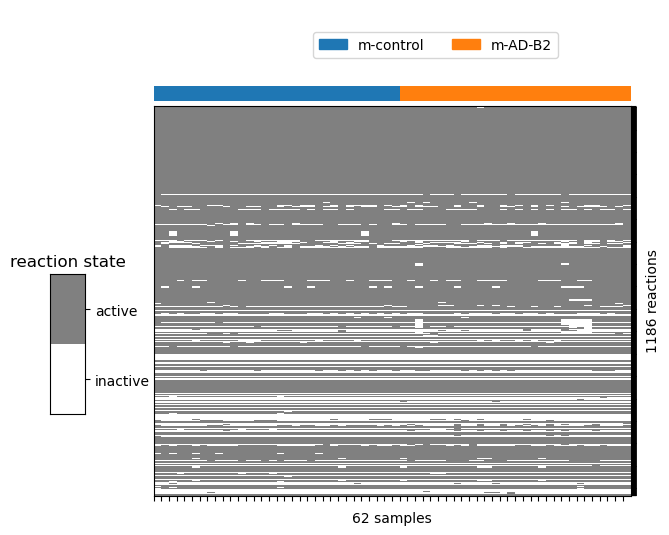

In [9]:
g = my_clustermap(fatty_acid_pathway)

In [10]:
def subsys2fname(subsys):
    fname = re.sub('[ ()]+', '-', subsys).strip('-')
    return(fname)

subsys2fname('Beta oxidation of unsaturated fatty acids (n-7) (mitochondrial)')

'Beta-oxidation-of-unsaturated-fatty-acids-n-7-mitochondrial'

/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:805: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


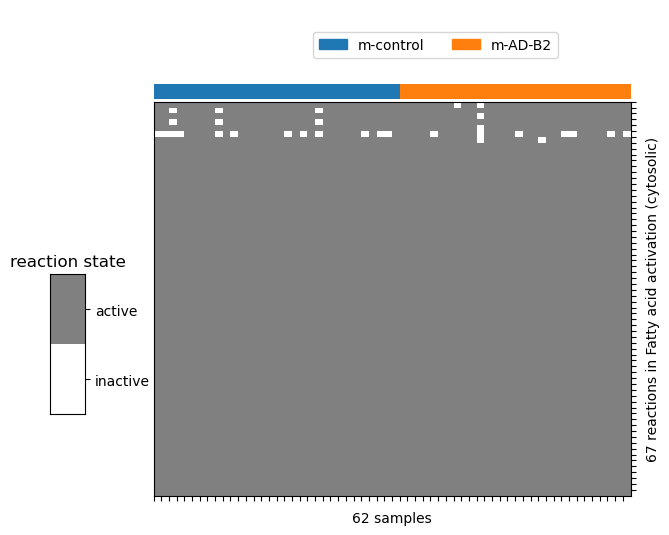

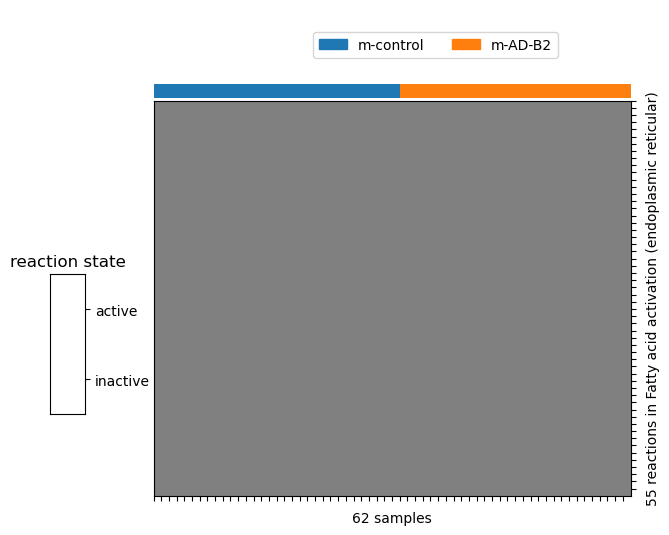

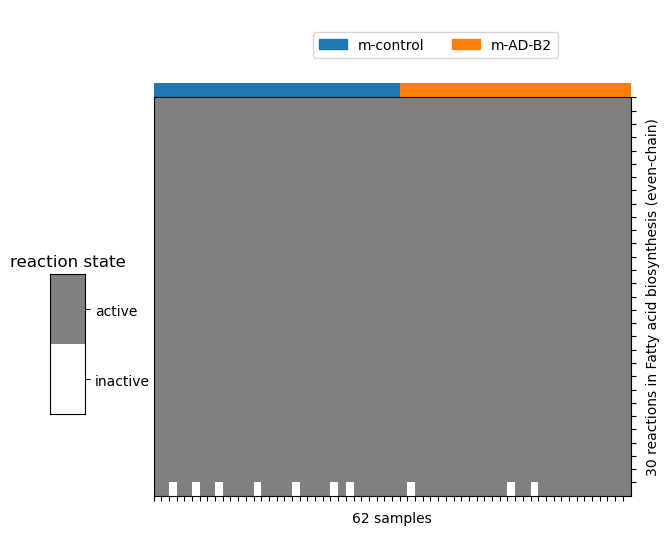

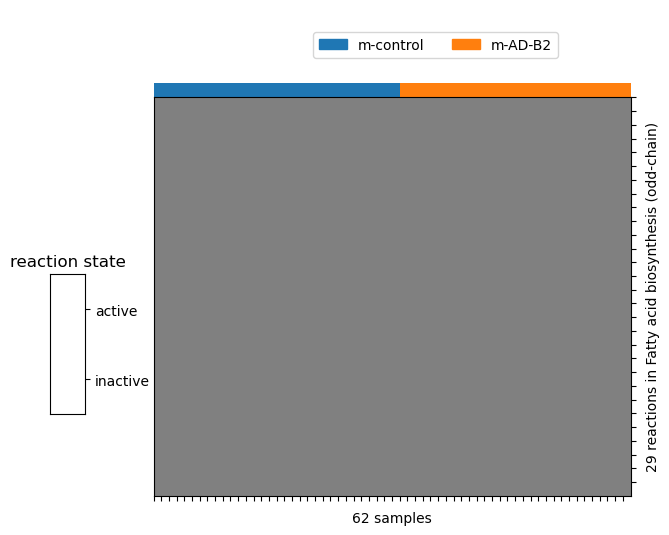

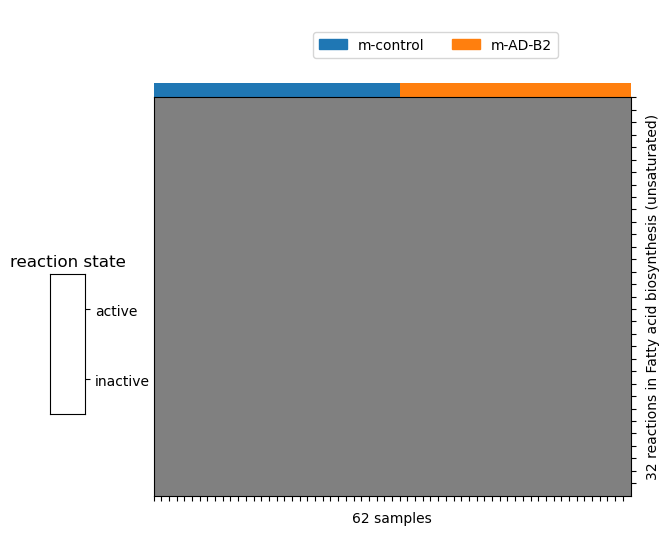

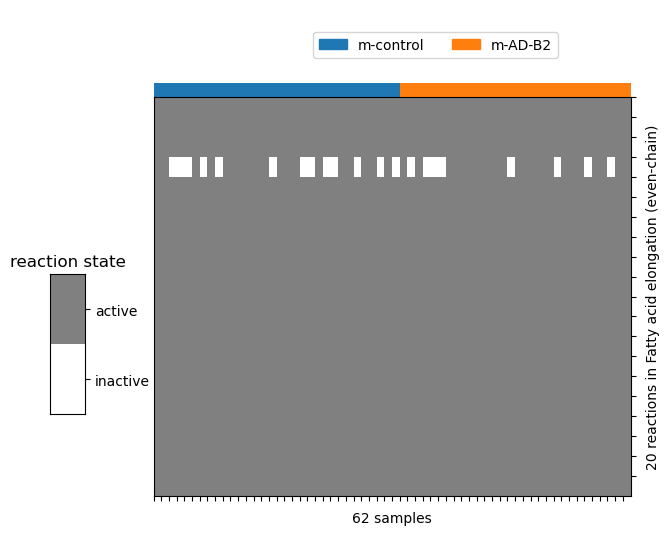

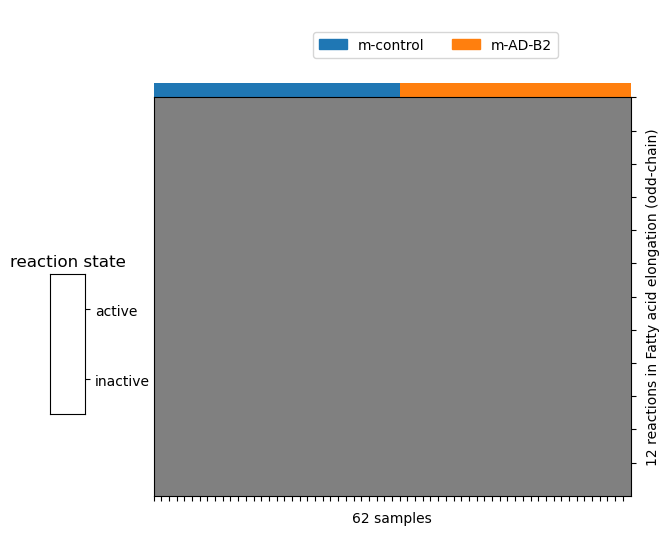

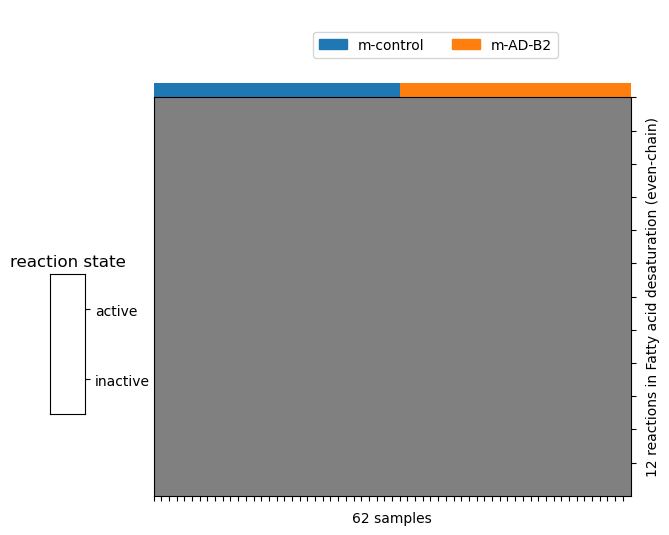

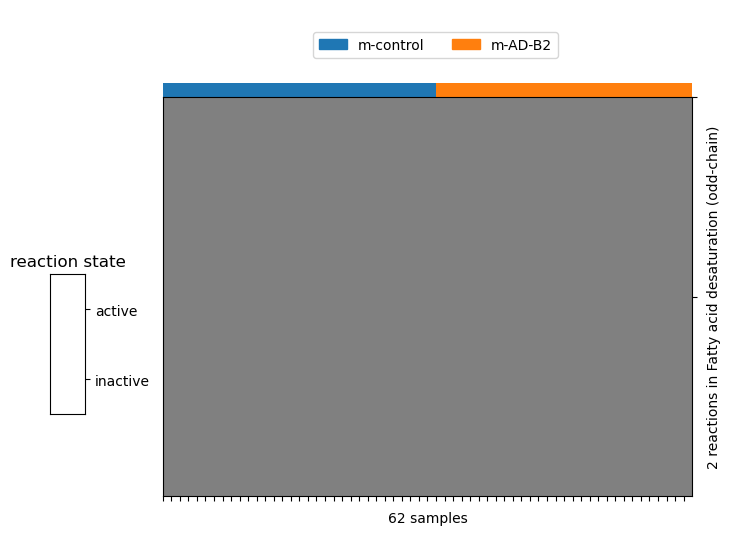

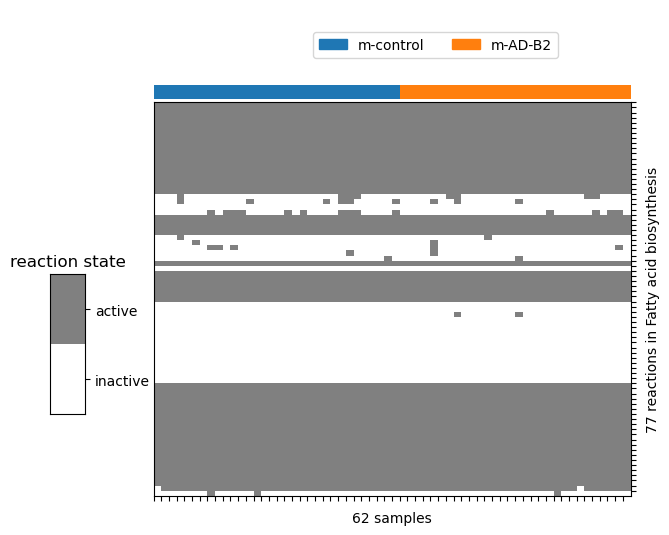

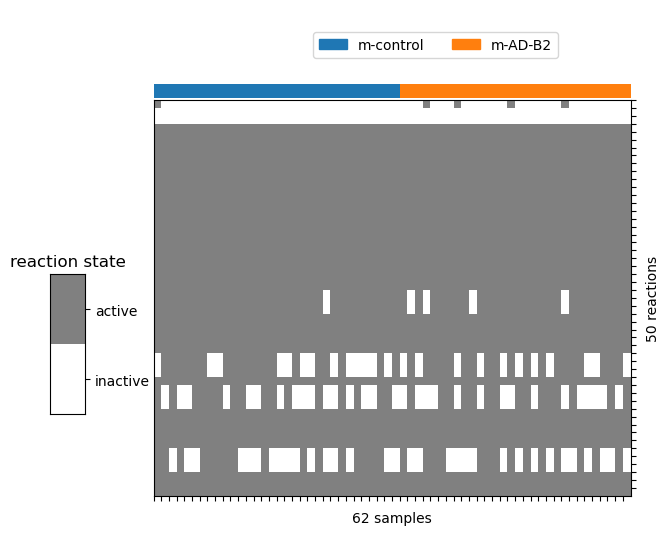

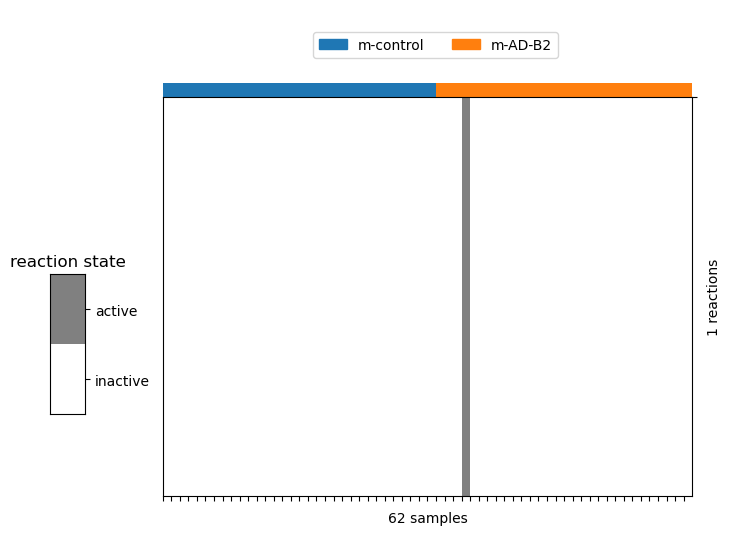

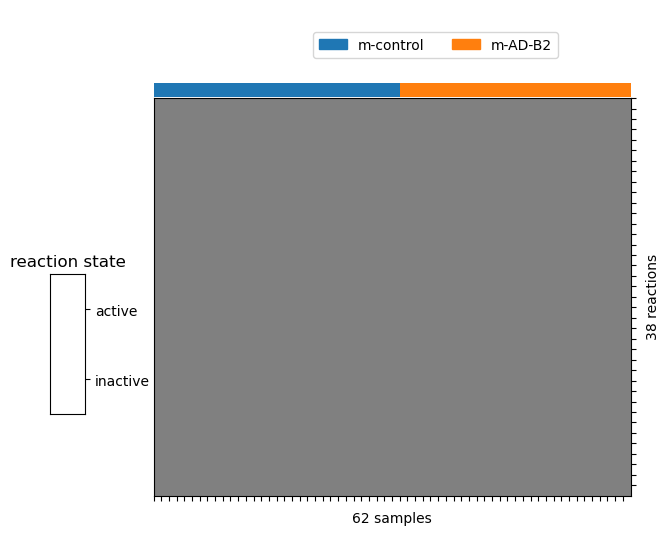

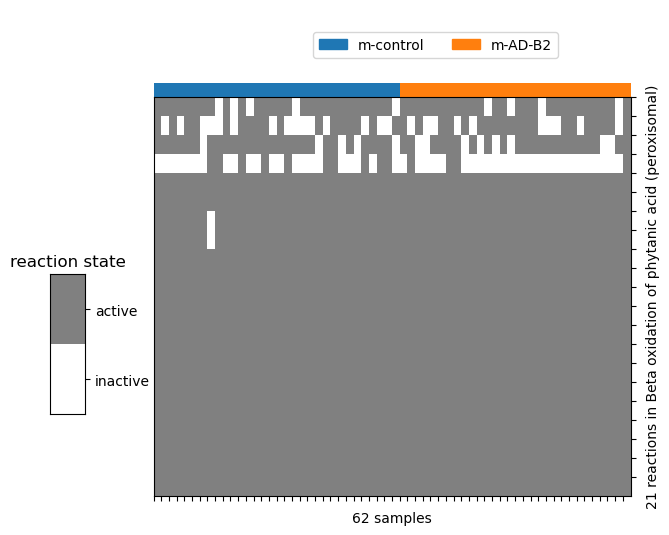

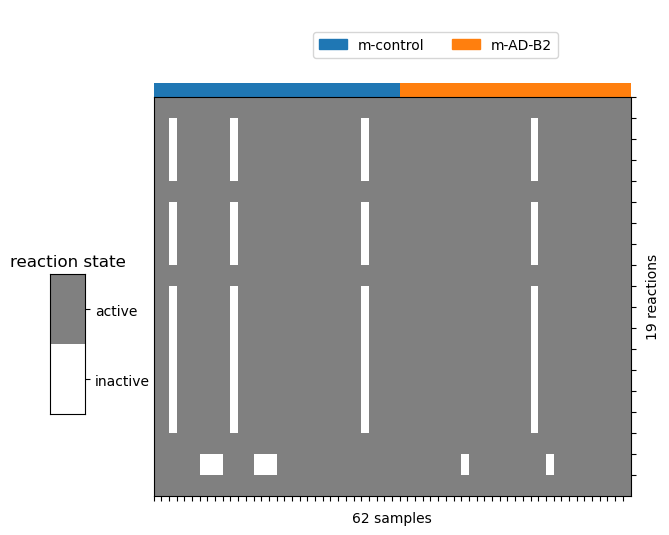

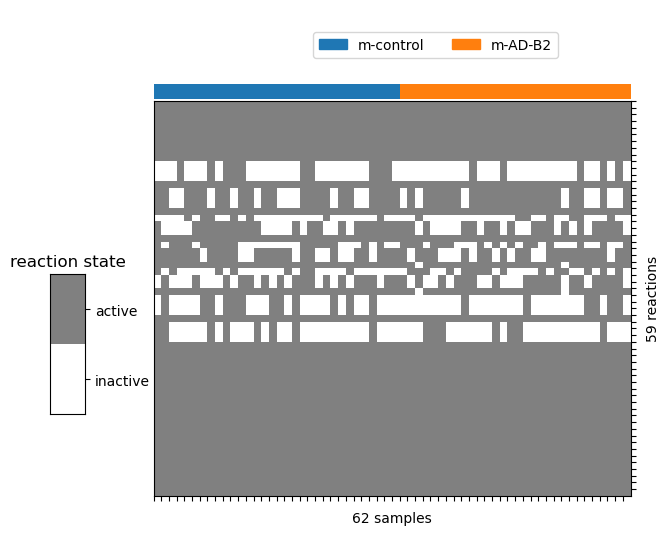

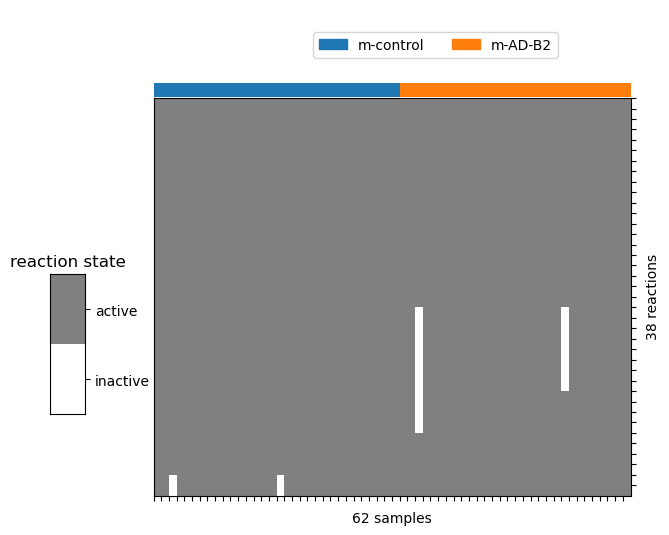

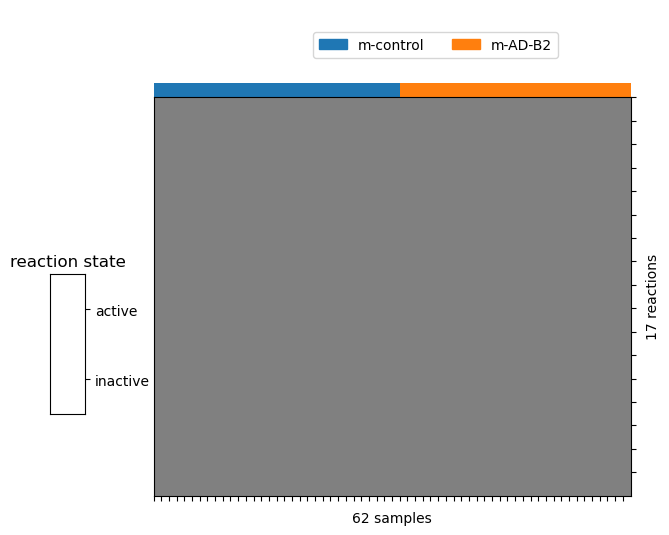

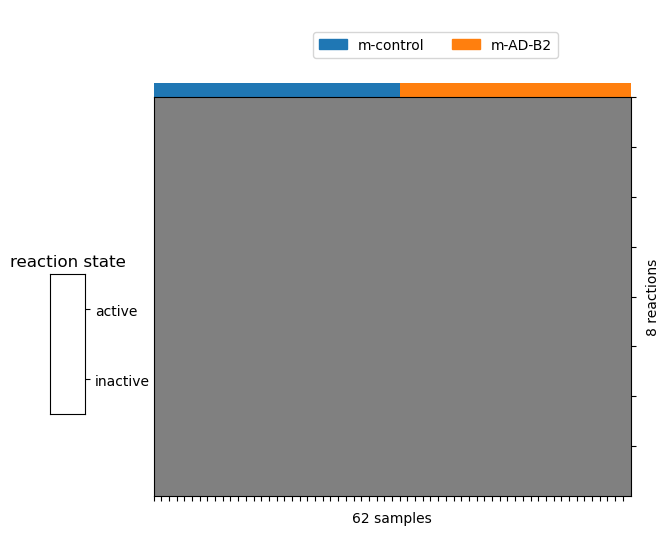

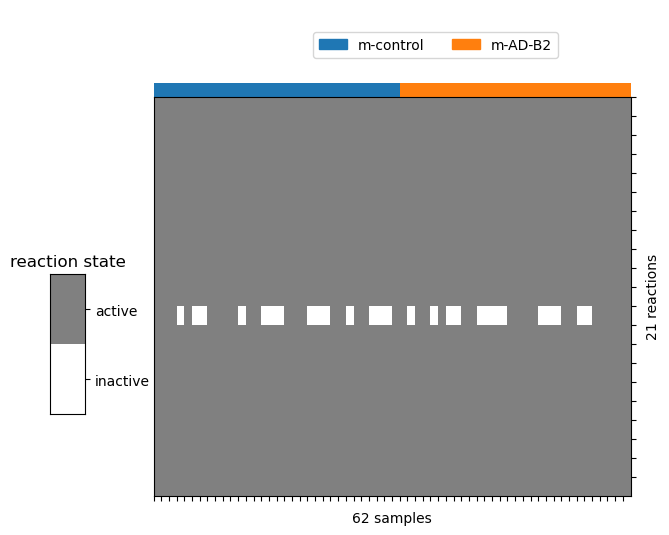

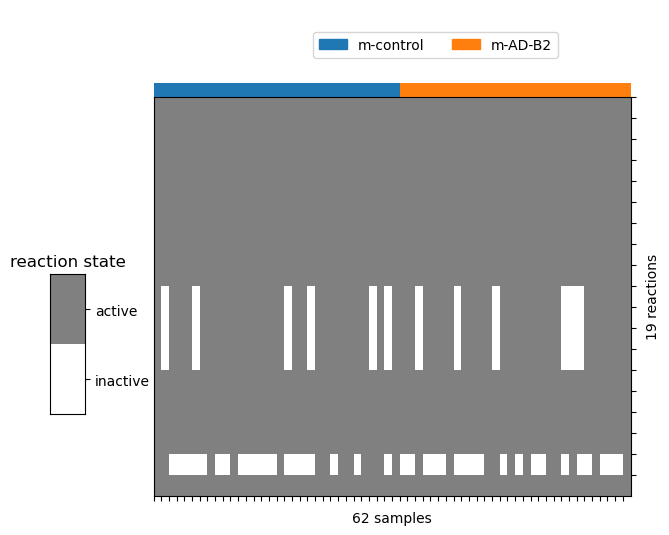

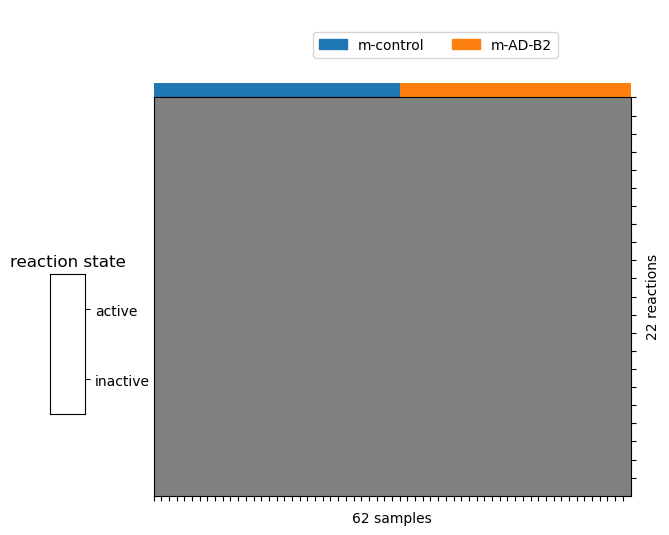

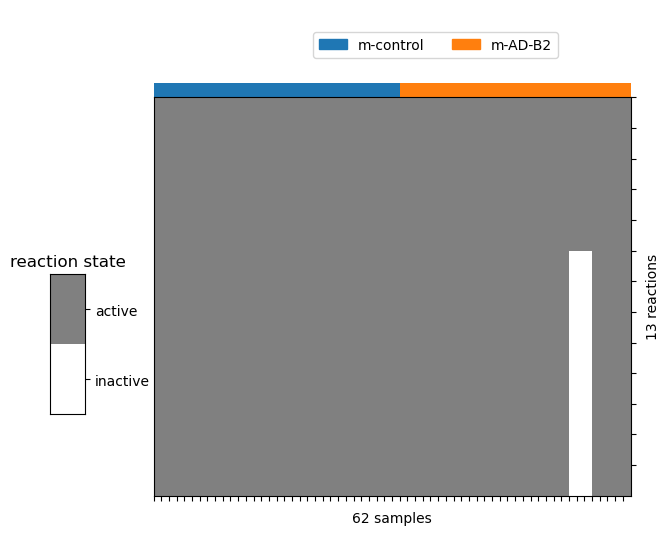

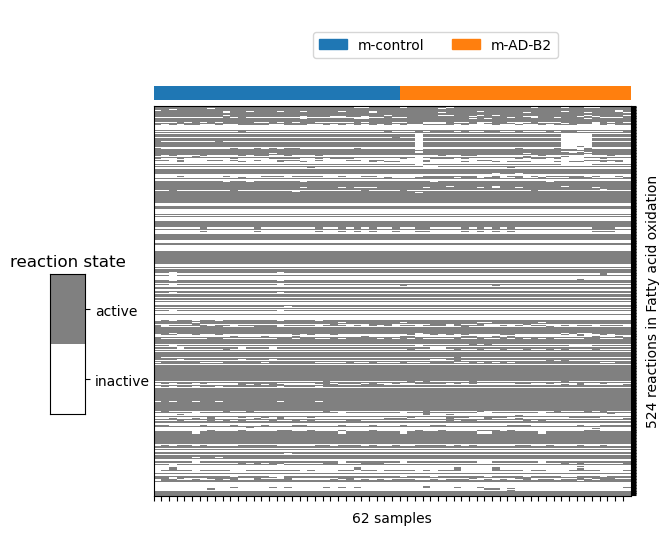

In [11]:
for subsys in fatty_acid_pathway:
    g = my_clustermap([subsys])
    attila_utils.savefig(g, subsys2fname(subsys))

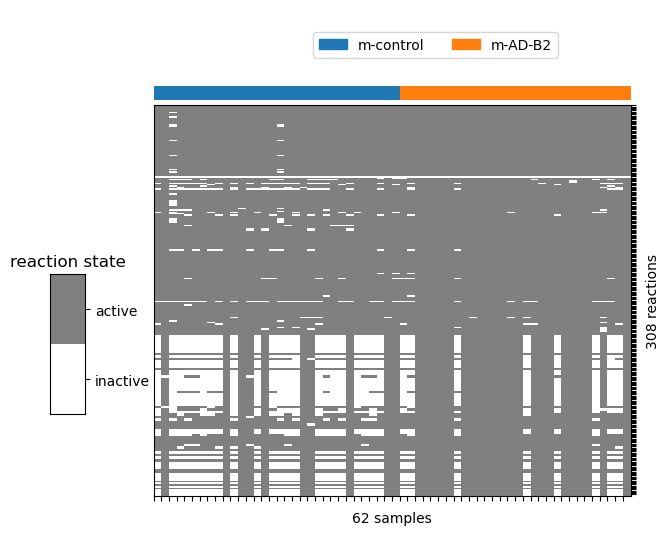

In [12]:
carnitine_pathway = pathways.loc['Carnitine shuttle']
g = my_clustermap(carnitine_pathway)
#g.fig.suptitle('Carnitine shuttle', y=1)

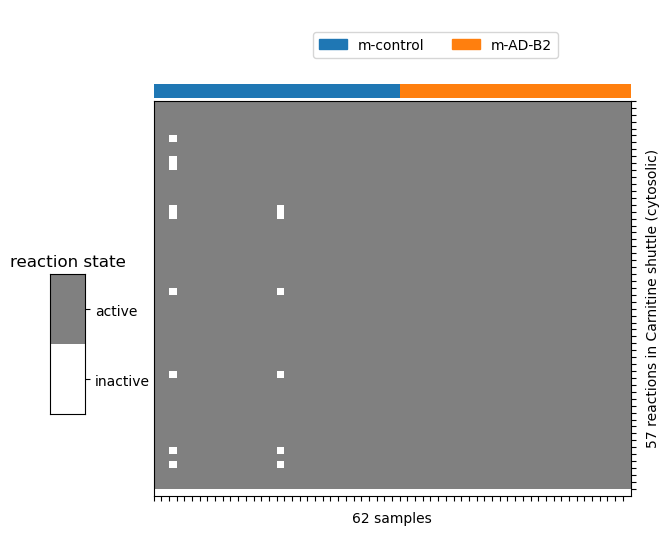

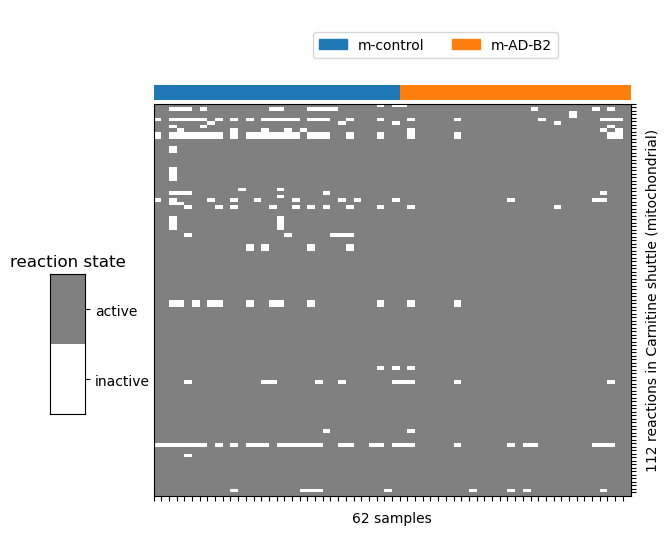

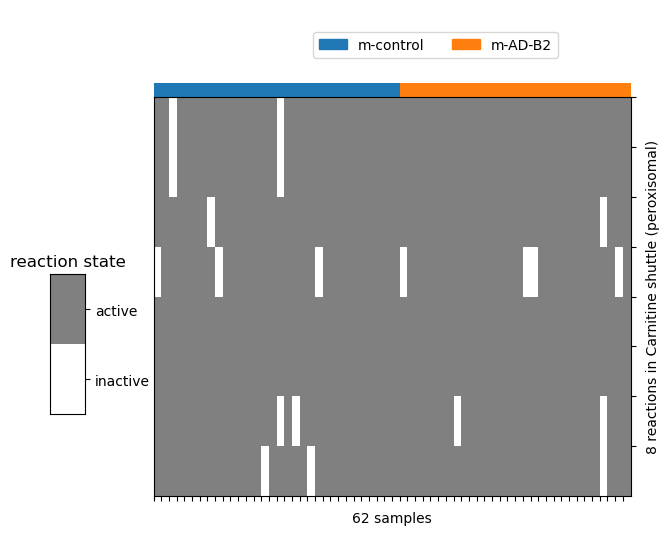

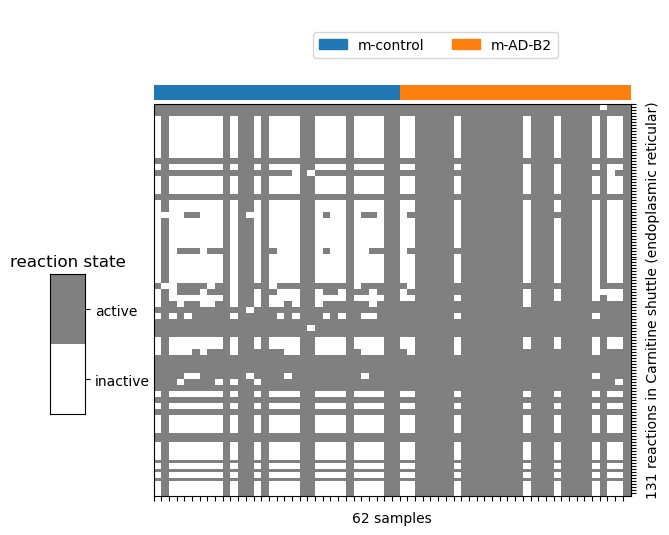

In [13]:
for subsys in carnitine_pathway:
    g = my_clustermap([subsys])
    attila_utils.savefig(g, subsys2fname(subsys))

In [14]:
def reshape2long(df, disease_state):
    long = df.stack().to_frame('rxn_state')
    long['rxn_state'] = np.int8(long.rxn_state)
    long['disease_state'] = disease_state
    long['rxn_ID'] = long.index.get_level_values(0)
    long['subject_ID'] = long.index.get_level_values(1)
    return(long)

def long_ar_subsys(subsystems, ar=ar, gemsubsys=gemsubsys):
    l = [reshape2long(ar[k].loc[gemsubsys.loc[gemsubsys.isin(subsystems)].index], k) for k in ar.keys()]
    long = pd.concat(l, axis=0)
    return(long)

## Bayesian mixed effects logistic regression

Let $x=1$ encode an AD `disease_state`, and $x=0$ encode control.

The [inline documentation of the statsmodels.genmod.bayes_mixed_glm module](https://www.statsmodels.org/stable/_modules/statsmodels/genmod/bayes_mixed_glm.html) reveals that

* the error distribution $Y$ given the linear predictor $\eta$ is Bernoulli $Y \sim \mathrm{Binom}(n=1, p)$
* link function $g(\mu) = \mathrm{E}_b(\eta) = x\beta + Zb$ is logit:
\begin{equation}
\mathrm{E}_b(\eta) = \mathrm{E}_b(x\beta + Zb) = x\beta = \mathrm{logit}(\pi) = \mathrm{log}(\pi / (1 - \pi))
\end{equation}
    * The first equation follows from $\mathrm{E}_b(b) = 0$ since $b \sim N(0, G)$, i.e $b$ is normally distributed with mean 0
    * The second equation follows from $x\beta = \eta = g(\mu)$, where the link function $g = \mathrm{logit}$ and from $\mathrm{E}(Y \, |\, \eta) = \mu = \pi$, where $\pi$ is the expected proportion of active reactions ($Y=1$)
    * The last expression $\mathrm{log}(\pi / (1 - \pi))$ is the posterior log odds

Therefore
\begin{eqnarray}
x\beta &=& \mathrm{log} \frac{\pi(x)}{1 - \pi(x)} \\
\beta &=& \mathrm{log} \frac{\pi(x=1)}{1 - \pi(x=1)} \; \Leftrightarrow \; e^\beta = \frac{\pi(x=1)}{1 - \pi(x=1)}
\end{eqnarray}
which means that we can interpret $\beta$ as the posterior log odds ratio of reaction state for AD w.r.t control.  (Note that if $x=0 \Rightarrow 0\beta = 0 = \mathrm{log}(\pi(x=0) / (1 - \pi(x=0)))$, so that the second equation above follows from the first one.)


It follows that the log odds ratio

In [15]:
def myBinomialBayesMixedGLM(subsys, control_group='m-control', AD_group='m-AD-B2', vcp_p=0.2, fe_p=2, fit_method='fit_vb', ar=ar, gemsubsys=gemsubsys):
    #print('Subsystem(s): ' + ', '.join(subsys))
    data = long_ar_subsys(subsys, ar=ar, gemsubsys=gemsubsys)
    if data.rxn_state.std() == 0:
        return(None)
    random = {'Reactions': 'rxn_ID', 'Subjects': 'subject_ID'}
    formula = 'rxn_state ~ C(disease_state, levels=["' + control_group + '", "' + AD_group + '"])'
    md = BinomialBayesMixedGLM.from_formula(formula, random, data, vcp_p=vcp_p, fe_p=fe_p)
    fit = getattr(md, fit_method)
    res = fit()
    return(res)

def print_results(subsys, vcp_p=0.2, fe_p=2):
    print('Subsystem(s): ' + ', '.join(subsys))
    for fit_method_name, fit_method in zip(['variational Bayes', 'Laplace approximation'], ['fit_vb', 'fit_map']):
        res = myBinomialBayesMixedGLM(subsys, vcp_p=vcp_p, fe_p=fe_p, fit_method=fit_method)
        print('\n' * 2, 'Fit method: ' + fit_method_name, '\n', res.summary())
    return(None)

print_results(['Carnitine shuttle (endoplasmic reticular)'])

Subsystem(s): Carnitine shuttle (endoplasmic reticular)


 Fit method: variational Bayes 
                                         Binomial Mixed GLM Results
                                                             Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
-----------------------------------------------------------------------------------------------------------
Intercept                                                       M     0.0420   0.0738                      
C(disease_state, levels=["m-control", "m-AD-B2"])[T.m-AD-B2]    M     8.8931   0.1421                      
Reactions                                                       V     1.5179   0.0525 4.563   4.108   5.068
Subjects                                                        V     1.6684   0.0656 5.304   4.652   6.047
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations


 Fit method: Laplace approximation 
                               

In [16]:
print_results(['Sphingolipid metabolism'])

Subsystem(s): Sphingolipid metabolism


/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))
/Users/jonesa7/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/bayes_mixed_glm.py:1069: RuntimeWarning: overflow encountered in exp
  return -np.log(1 + np.exp(tm + np.sqrt(tv) * z))




 Fit method: variational Bayes 
                                         Binomial Mixed GLM Results
                                                             Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
-----------------------------------------------------------------------------------------------------------
Intercept                                                       M    -0.2209   0.0446                      
C(disease_state, levels=["m-control", "m-AD-B2"])[T.m-AD-B2]    M     0.1362   0.0641                      
Reactions                                                       V     1.7017   0.0518 5.483   4.943   6.083
Subjects                                                        V    -0.4121   0.0883 0.662   0.555   0.790
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations


 Fit method: Laplace approximation 
                                         Binomial Mixed GLM Results
                   

In [17]:
fpath = '../../results/2023-02-10-gem-subsystems/fitted_models.pickle'
if os.path.exists(fpath):
    print('exists')
    with open(fpath, 'rb') as f:
        fitted_models = pickle.load(f)
else:
    subsystems = gemsubsys.unique()
    d = {subsys: myBinomialBayesMixedGLM([subsys], 'm-control', 'm-AD-B2', vcp_p=0.2, fe_p=2, fit_method='fit_map') for subsys in subsystems}
    fitted_models = {'m-AD-B2 wrt m-control': pd.Series(d)}
    with open(fpath, 'wb') as f:
        pickle.dump(fitted_models, f)

fittedm = fitted_models['m-AD-B2 wrt m-control']

exists


In [28]:
fe = pd.concat([fittedm.dropna().apply(lambda m: getattr(m, fe)[1]).to_frame(fe) for fe in ['fe_mean', 'fe_sd']], axis=1)
fe = fe.sort_values('fe_mean', ascending=True)
fe

,fe_mean,fe_sd
Beta oxidation of branched-chain fatty acids (mitochondrial),-2.647663,0.681926
Glycosylphosphatidylinositol (GPI)-anchor biosynthesis,-1.503024,0.226318
Beta oxidation of odd-chain fatty acids (mitochondrial),-1.323693,0.459133
Heme synthesis;Porphyrin metabolism,-1.180292,0.543679
Thiamine metabolism,-0.926869,0.270025
...,...,...
Glycosphingolipid biosynthesis-globo series,0.957221,0.265228
Beta oxidation of di-unsaturated fatty acids (n-6) (peroxisomal),1.098072,0.463555
Carnitine shuttle (cytosolic),1.193071,0.444022
Carnitine shuttle (mitochondrial),1.646018,0.267293


In [29]:
def exp_transform(fe, alpha=0.005):
    fe = fe.copy()
    fe['OR'] = fe.fe_mean.apply(np.exp)
    half_CI = fe.fe_sd.apply(lambda x: scipy.stats.norm.ppf(1 - alpha, loc=0, scale=x))
    fe['Lbound'] = (fe.fe_mean - half_CI).apply(np.exp)
    fe['Ubound'] = (fe.fe_mean + half_CI).apply(np.exp)
    fe['Lhalf_CI'] = fe['OR'] - fe['Lbound']
    fe['Uhalf_CI'] = fe['Ubound'] - fe['OR']
    return(fe)

fe_shortened = pd.concat([fe.head(15), pd.DataFrame({'fe_mean': [np.nan], 'fe_sd': [np.nan]}, index=['...']), fe.tail(15)])
exp_transform(fe_shortened)

,fe_mean,fe_sd,OR,Lbound,Ubound,Lhalf_CI,Uhalf_CI
Beta oxidation of branched-chain fatty acids (mitochondrial),-2.647663,0.681926,0.070817,0.012226,0.410189,0.058591,0.339373
Glycosylphosphatidylinositol (GPI)-anchor biosynthesis,-1.503024,0.226318,0.222456,0.124185,0.398492,0.098271,0.176036
Beta oxidation of odd-chain fatty acids (mitochondrial),-1.323693,0.459133,0.266151,0.081566,0.868451,0.184585,0.602300
Heme synthesis;Porphyrin metabolism,-1.180292,0.543679,0.307189,0.075720,1.246241,0.231469,0.939052
Thiamine metabolism,-0.926869,0.270025,0.395791,0.197423,0.793477,0.198368,0.397686
Phenylalanine metabolism,-0.813129,0.329214,0.443468,0.189925,1.035485,0.253544,0.592016
Estrogen metabolism,-0.781764,0.307724,0.457598,0.207130,1.010940,0.250468,0.553342
Heme synthesis,-0.717185,0.448519,0.488124,0.153740,1.549798,0.334385,1.061673
Heme degradation,-0.631455,0.484701,0.531817,0.152596,1.853455,0.379221,1.321637
Glutathione metabolism,-0.586218,0.295503,0.556428,0.259920,1.191183,0.296508,0.634755


(<Figure size 400x800 with 1 Axes>,
 <AxesSubplot:title={'center':'Posterior mean OR; 99.9% credibile intreval'}, xlabel='OR: $\\frac{\\pi_a / (1 - \\pi_a)}{\\pi_b / (1 - \\pi_b)}$; $a =$m-AD-B2; $a =$m-control'>)

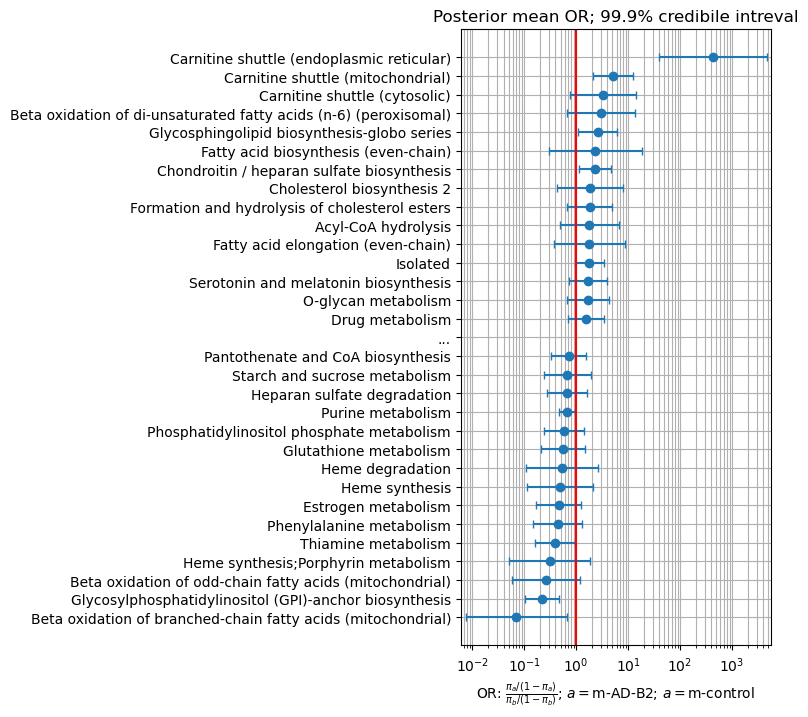

In [41]:
def credibility_plot(fe, alpha=0.0005, control_group='m-control', AD_group='m-AD-B2'):
    fe = exp_transform(fe, alpha=alpha)
    fig, ax = plt.subplots(figsize=(4, 8))
    ax.errorbar(x=fe.OR, y=list(range(fe.shape[0])), xerr=(fe.Lhalf_CI, fe.Uhalf_CI), linestyle='none', marker='o', capsize=3)
    ax.set_xscale('log')
    ax.set_xlim([0.8 * fe.Lbound.min(), 1.2 * fe.Ubound.max()])
    ax.set_yticks(list(range(fe.shape[0])))
    ax.set_yticklabels(fe.index)
    ax.grid(which='both')
    ax.axvline(1, color='red')
    ax.set_title(r'Posterior mean OR; ' + str(100 * (1 - 2 * alpha)) + '% credibile intreval')
    ax.set_xlabel(r'OR: $\frac{\pi_a / (1 - \pi_a)}{\pi_b / (1 - \pi_b)}$; $a =$' + AD_group + r'; $a =$' + control_group)
    return((fig, ax))

credibility_plot(fe_shortened)

In [31]:
%connect_info

{
  "shell_port": 60991,
  "iopub_port": 60992,
  "stdin_port": 60993,
  "control_port": 60995,
  "hb_port": 60994,
  "ip": "127.0.0.1",
  "key": "aa8faf30-900188302f7cdd0b144bd544",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d77e2bbe-c99d-4632-b4b8-ca73f539c5a1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
